A POSITIVE review:
bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   

A NEGATIVE review:
story of a man who has unnatural feelings for a pig . starts out with a opening scene that is a terrific example of absurd comed

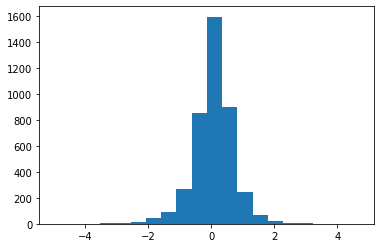

In [57]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline

# read data files 
cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory


g = open('reviews.txt','r') # What we know!
reviews_all = list(map(lambda x:x[:-1],g.readlines()))
g.close()
g = open('labels.txt','r') # What we WANT to know!
sentiments_all = list(map(lambda x:x[:-1].upper(),g.readlines()))
g.close()

# load vocabulary
g = open('vocab.txt','r')
vocab = [s.strip() for s in g.readlines()]

# Check out sample reviews
print('A {} review:'.format(sentiments_all[0]))
print(reviews_all[0])
print('\nA {} review:'.format(sentiments_all[1]))
print(reviews_all[1])

# split into training and test data
reviews_train,reviews_test = reviews_all[0:24000],reviews_all[24000:]
sentiments_train,sentiments_test = sentiments_all[0:24000],sentiments_all[24000:]

# maintain Counter objects to store positive, negative and total counts for
# all the words present in the positive, negative and total reviews.
positive_word_count = Counter()
negative_word_count = Counter()
total_counts = Counter()

# and increment the counts in the appropriate counter objects
# based on the training data

for word, label in zip(reviews_train, sentiments_train):
    
    word_list = word.split()
    
    if label=="POSITIVE":
        positive_word_count.update(word_list)
        
    if label=="NEGATIVE":
        negative_word_count.update(word_list)
        
    total_counts.update(word_list)

print(positive_word_count.most_common()[:10],"\n")
print(negative_word_count.most_common()[-10:-1],"\n")
print(total_counts.most_common()[:10],"\n")

# maintain a Counter object to store positive to negative ratios 
pos_neg_ratios = Counter()

# Calculate the ratios of positive and negative uses of the most common words
# Consider words to be "common" if they've been used at least 100 times
for term,cnt in (total_counts.most_common()):
    if(cnt > 100):
        word = term.split()
        if negative_word_count[term]!=0:
            ratio = positive_word_count[term]/negative_word_count[term]
        else:
            ratio = positive_word_count[term]
            
        pos_neg_ratios.update(word)
        pos_neg_ratios[term]=ratio
        
print(pos_neg_ratios.most_common()[:10],"\n")
print(pos_neg_ratios.most_common()[-10:-1],"\n")

print("Pos-to-neg ratio for 'the' = {}".format(pos_neg_ratios["the"]))
print("Pos-to-neg ratio for 'amazing' = {}".format(pos_neg_ratios["amazing"]))
print("Pos-to-neg ratio for 'terrible' = {}".format(pos_neg_ratios["terrible"]))

# take a log of the ratio
for word,ratio in pos_neg_ratios.most_common():
    pos_neg_ratios[word] = np.log(ratio)
print(pos_neg_ratios.most_common()[:10])

# visualize the distribution of the log-ratio scores
scores = np.array(list(pos_neg_ratios.values()))
vocab_selected = list(pos_neg_ratios.keys())

h = plt.hist(scores,bins=20)

# Print few words with neutral score
for ind in np.where(scores == 0)[0][0:10]:
    print(vocab_selected[ind])


def nonml_classifier(review,pos_neg_ratios):
    '''
    Function that determines the sentiment for a given review.
    
    Inputs:
      review - A text containing a movie review
      pos_neg_ratios - A Counter object containing frequent words
                       and corresponding log positive-negative ratio
    Return:
      sentiment - 'NEGATIVE' or 'POSITIVE'
    '''
    
    reviews = "POSITIVE NEGATIVE NEUTRAL"
    
    pos_neg_reviews = Counter(reviews.split())
    
    word_list = review.split(" ")
    
    for word in word_list:
        if pos_neg_ratios[word] >= 0.5:
            pos_neg_reviews.update(['POSITIVE'])
        elif pos_neg_ratios[word] < 0.5 and pos_neg_ratios[word] > -0.5:
            pos_neg_reviews.update(['NEUTRAL'])
        else:
            pos_neg_reviews.update(['NEGATIVE'])
            
    if pos_neg_reviews['POSITIVE'] > pos_neg_reviews['NEGATIVE']:
        return 'POSITIVE'
    else:
        return 'NEGATIVE'

predictions_test = []
for r in reviews_test:
    l = nonml_classifier(r,pos_neg_ratios)
    predictions_test.append(l)

# calculate accuracy
correct = 0
for l,p in zip(sentiments_test,predictions_test):
    if l == p:
        correct = correct + 1
print('Accuracy of the model = {}'.format(correct/len(sentiments_test)))


def create_input_vector(review,word2index):
    '''
    Function to count how many times each word is used in the given review,
    # and then store those counts at the appropriate indices inside x.
    '''
    vocab_size = len(word2index)
    x = np.zeros((1, vocab_size))
    for w in review.split(' '):
        if w in word2index.keys():
            x[0][word2index[w]] += 1
    return x

def find_ignore_words(pos_neg_ratios):
    ignore_words = []
    for word in word_list:
        if pos_neg_ratios[word] < 0.5 and pos_neg_ratios[word] > -0.5:
            del pos_neg_ratios[word]        
    return ignore_words

# create a word2index mapping from word to an integer index
word2index = {}
ignore_words = find_ignore_words(pos_neg_ratios)
vocab_selected = list(set(vocab_selected).difference(set(ignore_words)))
for i,word in enumerate(vocab_selected):
    if word not in ignore_words:
        word2index[word] = i
vocab_size = len(word2index)

# Run the script once to generate the file 
# delete the exiting 'data1.hdf5' file before running it again to avoid error 
labels_train = np.zeros((len(sentiments_train), 2), dtype=int)
labels_test = np.zeros((len(sentiments_test), 2), dtype=int)

import h5py
with h5py.File('data1.hdf5', 'w') as hf:
    hf.create_dataset('data_train', (labels_train.shape[0], vocab_size), np.int16)
    hf.create_dataset('data_test', (labels_test.shape[0], vocab_size), np.int16)
  # create training data
    for i,(r,l) in enumerate(zip(reviews_train, sentiments_train)):
        hf["data_train"][i] = create_input_vector(r,word2index)
        # one-hot encoding
        if l == 'NEGATIVE':
            labels_train[i, 0] = 1
        else:
            labels_train[i, 1] = 1
    # create test data
    for i,(r,l) in enumerate(zip(reviews_test, sentiments_test)):
        hf["data_test"][i] = create_input_vector(r,word2index)
        # one-hot encoding
        if l == 'NEGATIVE':
            labels_test[i, 0] = 1
        else:
            labels_test[i, 1] = 1

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
tf.compat.v1.random.set_random_seed(10)


# parameters of the network
learning_rate = 0.01
batch_size = 400
num_epochs = 50
n_input = vocab_size
n_classes = 2


X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# Define weights and biases in Tensorflow according to the parameters set above
n_hidden_1 = 10  # 1st layer number of neurons
weights = {
	'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
	'out1': tf.Variable(tf.random_normal([n_hidden_1, n_classes]))
}
biases = {
	'b1': tf.Variable(tf.random_normal([n_hidden_1])),
	'out2': tf.Variable(tf.random_normal([n_classes]))
}

#value of hidden layers should be lesser than or equal to n_hidden_1 ,second layer
#please uncomment this section for the second layer.
n_hidden_2 = 10
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out1': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out2': tf.Variable(tf.random_normal([n_classes]))
    }

#value of hidden layers should be lesser than or equal to n_hidden_2 ,third layer 
#please uncomment this section for the third layer.

# n_hidden_3 = 10
# weights = {
#     'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
#     'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
#     'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
#     'out1': tf.Variable(tf.random_normal([n_hidden_3, n_classes]))
# }
# biases = {
#     'b1': tf.Variable(tf.random_normal([n_hidden_1])),
#     'b2': tf.Variable(tf.random_normal([n_hidden_2])),
#     'b3': tf.Variable(tf.random_normal([n_hidden_3])),
#     'out3': tf.Variable(tf.random_normal([n_classes]))
#     }



def multilayer_perceptron(x):
    # define the layers of a single layer perceptron
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])

    #Please comment this line for layer2 and layer3
    #out_layer = tf.nn.sigmoid(tf.matmul(layer_1, weights['out1']) + biases['out2'])
    
    #for layer 1 and layer3 comment the below out_layer  and uncomment layer2
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    out_layer = tf.nn.sigmoid(tf.matmul(layer_2, weights['out1']) + biases['out2'])

     #for layer 1 and layer 2 comment the below out_layer and uncomment layer3
    # layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])
    # out_layer = tf.nn.sigmoid(tf.matmul(layer_3, weights['out1']) + biases['out3'])

    return out_layer

logits = multilayer_perceptron(X)
# Define loss(softmax_cross_entropy_with_logits) and optimizer(AdamOptimizer)
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
# Initializing the variables
init = tf.global_variables_initializer()


# for some macosx installations, conflicting copies of mpilib causes trouble with tensorflow.
# use the following two lines to resolve that issue
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

with tf.Session() as sess:
    start_time = time.time()
    sess.run(init)

    h = h5py.File('data1.hdf5', 'r')
    n1 = h.get('data_train') 
    n2 = h.get('data_test')

    # Training cycle
    total_batch_train = int(n1.shape[0] / batch_size)
    total_batch_test = int(n2.shape[0] / batch_size)

    for iter_num in range(num_epochs):
        # variables for train and test accuracies
        avg_acc_train = 0.
        avg_acc_test = 0.
        for i in range(total_batch_train):
            train_x = n1[(i) * batch_size: (i + 1) * batch_size, ...]
            train_y = labels_train[(i) * batch_size: (i + 1) * batch_size, :]

            _, c_train, _logits_train = sess.run([train_op, loss_op, logits], feed_dict={X: train_x, Y: train_y})
            _label_train = [np.argmax(i) for i in _logits_train]
            _label_train_y = [np.argmax(i) for i in train_y]
            _accuracy_train = np.mean(np.array(_label_train) == np.array(_label_train_y))
            avg_acc_train += _accuracy_train


        for j in range(total_batch_test):
            test_x = n2[(j) * batch_size: (j + 1) * batch_size, ...]
            test_y = labels_test[(j) * batch_size: (j + 1) * batch_size, :]

            c_test, _logits_test = sess.run([loss_op, logits], feed_dict={X: test_x, Y: test_y})
            _label_test = [np.argmax(i) for i in _logits_test]
            _label_test_y = [np.argmax(i) for i in test_y]
            _accuracy_test = np.mean(np.array(_label_test) == np.array(_label_test_y))
            avg_acc_test += _accuracy_test

        # print the train and test accuracies   
        print("Train acc: %f, Test_acc: %f" % (avg_acc_train/total_batch_train, avg_acc_test/total_batch_test))
    duration = time.time() - start_time
    print('Time elapsed - {} seconds.'.format(duration))





